In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import lightgbm as lgb

plt.rcParams['figure.figsize'] = (15.0, 10.0)

In [2]:
data_chemicals = pd.read_csv("chemicals.csv", encoding = "utf-8")
data_drought = pd.read_csv("droughts.csv", encoding = "utf-8")
data_education = pd.read_csv("education_attainment.csv", encoding = "latin1")
data_industry_occupation = pd.read_csv("industry_occupation.csv", encoding="latin1")
data_industry_earnings = pd.read_csv("earnings.csv", encoding="latin1")

### National chemical index

In [3]:
data_chemicals['greater_than_MCL'] = (data_chemicals['contaminant_level'] == "Greater than MCL") * 1.

In [4]:
groups = data_chemicals.groupby(["year", "pws_id"])['pop_served', 'greater_than_MCL'].mean()
groups['greater_than_MCL'] *= data_chemicals.groupby(["year", "pws_id"])['greater_than_MCL'].count()
groups['index_weight'] = groups['pop_served'] * groups['greater_than_MCL']

final_groups = groups.groupby("year")['index_weight'].sum() / groups.groupby("year")['pop_served'].sum()

final_groups_polluted = groups[groups['greater_than_MCL']>=1.]
final_groups_polluted = final_groups_polluted.groupby("year")['index_weight'].sum() / final_groups_polluted.groupby("year")['pop_served'].sum()

In [ ]:
final_groups.plot()
plt.grid()

In [ ]:
import statsmodels.api as sm

In [ ]:
X = final_groups.index.values - 1999.
Y = final_groups.values
L = LinearRegression()
L.fit(X.reshape(-1,1), Y)
L.coef_

In [ ]:
plt.plot(X, Y)

In [ ]:
final_groups_polluted.plot()
plt.grid()

## Pollution index by county

In [5]:
data_chemicals = data_chemicals[data_chemicals['year']==2010]

In [6]:
data_chemicals = data_chemicals.set_index(data_chemicals['fips'])

In [7]:
groups = data_chemicals.groupby("cws_name")[['greater_than_MCL', 'fips', "pop_served"]].mean()
groups['greater_than_MCL'] *= data_chemicals.groupby("cws_name")['greater_than_MCL'].count()
groups['index_with_weights'] = groups['greater_than_MCL']*groups['pop_served']
groups['fips'] = groups['fips'].astype(int)
chemicals_index = groups.groupby("fips")['index_with_weights'].sum() / groups.groupby("fips")['pop_served'].sum()

## Drought index by county

In [ ]:
data_drought['valid_start'] = pd.to_datetime(data_drought['valid_start'])
data_drought['valid_end'] = pd.to_datetime(data_drought['valid_end'])

In [ ]:
data_drought['event_duration_in_days'] = (data_drought['valid_end'] - data_drought['valid_start']).dt.days

In [ ]:
data_drought['event_importance_with_weight'] = data_drought['event_duration_in_days'] * 0. + (data_drought['d0']*1. + data_drought['d1']*2. + data_drought['d2']*3. + data_drought['d3']*4. + data_drought['d4']*5.) / 100.
groups = data_drought.groupby("fips")
drought_index = groups['event_importance_with_weight'].sum() / groups['event_duration_in_days'].sum()

In [ ]:
data_drought

In [ ]:
drought_index

## Education index by county

In [ ]:
data_education

In [ ]:
data_education['avg_higher_education_years'] = (data_education['pct_less_than_hs'] * (-3) + data_education['pct_hs_diploma'] * 0. + data_education['pct_college_or_associates']*3. + data_education['pct_college_bachelors_or_higher']*4.)/100.

In [ ]:
education_index = data_education.groupby('fips')['avg_higher_education_years'].mean()

In [ ]:
education_index

In [ ]:
len(data_chemicals['fips'].unique())

In [ ]:
chemicals_index

## Analysis

In [ ]:
data_with_indices = pd.DataFrame({'drought': drought_index, 'chemicals': chemicals_index, 'education': education_index})

In [ ]:
data_with_indices

In [ ]:
data_with_indices = data_with_indices.dropna()

In [ ]:
data_with_indices['drought_normalized'] = (data_with_indices['drought'] - data_with_indices['drought'].mean()) /data_with_indices['drought'].std()
data_with_indices['chemicals_normalized'] = (data_with_indices['chemicals'] - data_with_indices['chemicals'].mean()) /data_with_indices['chemicals'].std()

In [ ]:
sns.scatterplot(data_with_indices['drought_normalized'].values, data_with_indices['chemicals_normalized'].values)
plt.grid()

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_with_indices[['drought_normalized', 'chemicals_normalized']].values)

In [ ]:
kmeans.labels_

In [ ]:
sns.scatterplot(data_with_indices['drought_normalized'].values, data_with_indices['chemicals_normalized'].values, c=kmeans.labels_)
plt.grid()

In [ ]:
LABEL_COLOR_MAP = {0: 'r',
                   1: 'g',
                   2: 'b'}

label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
plt.scatter(data_with_indices['drought_normalized'].values, data_with_indices['chemicals_normalized'].values, c=label_color)
plt.grid()

In [ ]:
data_with_indices[['chemicals', 'drought']].corr()

In [ ]:
sns.scatterplot(data_with_indices['chemicals'].values, data_with_indices['drought'].values)
plt.grid()

## Regression chemicals vs. industry total revenue

In [8]:
data_industry_earnings = data_industry_earnings[data_industry_earnings['year'] == 2010]
data_industry_occupation = data_industry_occupation[data_industry_occupation['year'] == 2010]

In [9]:
data_industry_occupation = data_industry_occupation.set_index(data_industry_occupation['fips'])
data_industry_earnings = data_industry_earnings.set_index(data_industry_earnings['fips'])

In [ ]:
# sector_corres = {'agri_fish_hunt': ['agriculture'],
#                 #'mining_quarrying_oilgas_extract': ['mining'],
#                 'construction': ['construction'],
#                 'manufacturing': ['manufacturing'],
#                 'wholesale_trade': ['wholesale_trade'],
#                 'retail_trade': ['retail_trade'],
#                 'transport_warehouse_utilities': ['transport_utilities'],
#                 'information': ['information'],
#                 'fin_ins_realest': ['finance_insurance_realestate'],
#                 'total_prof_sci_mgmt_admin': ['prof_scientific_waste', 'public_admin'],
#                 'total_edu_health_social': ['edu_health'],
#                 'total_arts_ent_acc_food': ['arts_recreation'],
#                 'other_ser': ['other']}

In [ ]:
# data_sectors = pd.DataFrame()
# for sector_earnings in sector_corres:
#         print(sector_earnings)
#         data_sectors[sector_earnings] = data_industry_earnings[sector_earnings] * data_industry_occupation[sector_corres[sector_earnings][0]]
#         for supp_sector in sector_corres[sector_earnings][1:]:
#             print('supp', supp_sector)
#             data_sectors[sector_earnings] = data_industry_earnings[sector_earnings] * data_industry_occupation[supp_sector]

In [25]:
sectors_occupation = ['agriculture', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 'transport_utilities', 'information', 'finance_insurance_realestate', 'prof_scientific_waste', 'edu_health', 'arts_recreation', 'other', 'public_admin']
industry_occ_pop = data_industry_occupation[sectors_occupation]
industry_occ_pop['chemicals'] = chemicals_index
industry_occ_pop['total_employed'] = data_industry_occupation['total_employed']
industry_occ_pop = industry_occ_pop.dropna()

for col in sectors_occupation:
    industry_occ_pop[col] = 100. * industry_occ_pop[col]/industry_occ_pop['total_employed']

X = industry_occ_pop[sectors_occupation]
Y = industry_occ_pop['chemicals']

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [26]:
sectors_occupation

['agriculture',
 'construction',
 'manufacturing',
 'wholesale_trade',
 'retail_trade',
 'transport_utilities',
 'information',
 'finance_insurance_realestate',
 'prof_scientific_waste',
 'edu_health',
 'arts_recreation',
 'other',
 'public_admin']

In [21]:
S = StandardScaler()
X = S.fit_transform(X.values)

In [22]:
L = LinearRegression()
L.fit(X, Y.values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

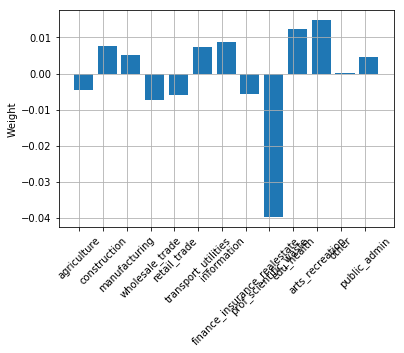

In [23]:
ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(sectors_occupation)
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight")
plt.show()

In [24]:
r2_score(Y.values.flatten(), L.predict(X))

0.03695043102626161

## Regression sur les earnings

In [ ]:
data_industry_earnings.columns

In [ ]:
sectors_earnings = ['total_agri_fish_mine', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 'transport_warehouse_utilities', 'information', 'fin_ins_realest', 'total_prof_sci_mgmt_admin', 'total_edu_health_social', 'total_arts_ent_acc_food', 'other_ser', 'pub_admin']

for sector in sectors_earnings:
    if(data_industry_earnings[sector].dtype != float):
        data_industry_earnings[sector] = data_industry_earnings[sector].str.replace(',','')
        data_industry_earnings[sector] = data_industry_earnings[sector].astype(float)

industry_earnings = data_industry_earnings[sectors_earnings]
industry_earnings['chemicals'] = chemicals_index
industry_earnings['total_med'] = data_industry_earnings['total_med']

for sector in sectors_earnings:
    industry_earnings[sector] = (industry_earnings[sector] - industry_earnings['total_med']) / industry_earnings['total_med']
    industry_earnings[sector] = (industry_earnings[sector] - industry_earnings[sector].mean()) / industry_earnings[sector].std()

industry_earnings = industry_earnings.dropna()

X = industry_earnings[sectors_earnings]
Y = industry_earnings['chemicals']

In [ ]:
L = Ridge()
L.fit(X.values, Y.values.reshape(-1,1))

In [ ]:
ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(sectors_earnings)
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight")
plt.show()

In [ ]:
r2_score(Y.values.flatten(), L.predict(X))

## Which sectors are most correlated with water pollution?

In this section, we provide insights on the link between the activity of various industry sectors and the level of water pollution in a large number of counties across the US.

### How can we measure water pollution?

The U.S. CDC regularly measures the concentration of a number of chemicals in water systems across the US. Based on these measurements for the years 2000-2016, we build a water pollution index using the following method:

For each chemical, we differentiate between two levels: $0$ if the current concentration of that chemical is below its median, and $1$ if it is above its median (that is to say if its current concentration is abnormally high). For a given water system, we then average these values across all chemicals, then compute an average across all the water systems in a given county, weighted by the population served by each water system.

This allows us to build a water pollution index between $0$ and $1$ for each county.

## Link between industry share and water pollution

In this section, we investigate the link between industry share and the water pollution index we previously built. Our ultimate goal is to determine whether the predominance of a given industry sector in a county can be linked to the presence of water pollution.

First of all, let us define the share of a given industry sector in a county as the percentage of the working population employed in this sector. More precisely:

$$ Industry\ share = 100 \times \frac{Population\ employed\ by\ industry}{Total\ working\ population\ in\ county}$$

**Hypothesis**: The shares of certain industry sectors is positively / negatively correlated with the pollution index.

*Remark: this approach does not differentiate between counties with large and small populations. This is roughly equivalent to assuming that a county's water reserves (which can be polluted by industries) are proportional to its population, which is a debatable assumption.*

Using a linear model, we build a predictive model of water pollution based on the industry share (both in 2010) of the following sectors:

- Agriculture
- Construction
- Manufacturing
- Wholesale trade
- Retail trade
- Transport and utilities
- Information
- Finance, insurance and real estate
- prof_scientific_waste
- Education and health
- Arts and entertainment
- Public administration
- Other

This leads to the following weights:

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


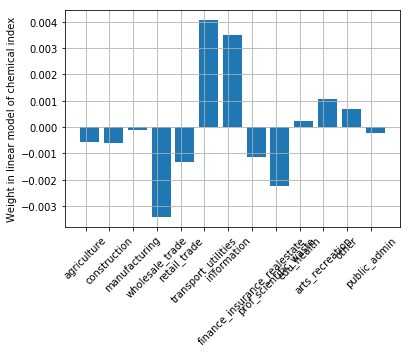

In [27]:
data_industry_earnings = data_industry_earnings[data_industry_earnings['year'] == 2010]
data_industry_occupation = data_industry_occupation[data_industry_occupation['year'] == 2010]

data_industry_occupation = data_industry_occupation.set_index(data_industry_occupation['fips'])
data_industry_earnings = data_industry_earnings.set_index(data_industry_earnings['fips'])

sectors_occupation = ['agriculture', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 'transport_utilities', 'information', 'finance_insurance_realestate', 'prof_scientific_waste', 'edu_health', 'arts_recreation', 'other', 'public_admin']
industry_occ_pop = data_industry_occupation[sectors_occupation]
industry_occ_pop['chemicals'] = chemicals_index
industry_occ_pop['total_employed'] = data_industry_occupation['total_employed']
industry_occ_pop = industry_occ_pop.dropna()

for col in sectors_occupation:
    industry_occ_pop[col] = 100. * industry_occ_pop[col]/industry_occ_pop['total_employed']

X = industry_occ_pop[sectors_occupation]
Y = industry_occ_pop['chemicals']

L = Ridge()
L.fit(X, Y.values.reshape(-1,1))

ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(sectors_occupation)
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight in linear model of chemical index")
plt.show()

## Link between industry profitability and water pollution

In this section, we investigate the link between the profitability of the various sectors and water pollution levels in U.S. counties. A good proxy for the profitability of an industry is the median revenue of the people it employs. To take account of the diversity of costs of living across the US, we instead consider these values relative to the median revenue in a given county (that is to say the profitability of a given sector w.r.t. the median revenue in the county). For a given sector, we then average these relative values across all counties in the US.

**Hypothesis**: the local profitability of some industries is positively or negatively correlated with the level of water pollution in a county.

We then fit a linear model to predict the level of water pollution given the county-level profitability of the following industry sectors:

- Agriculture, fishing and mining
- Construction
- Manufacturing
- Wholesale trade
- Retail trade
- Transport, warehouse and utilities
- Information
- Finance, insurance and real estate
- total_prof_sci_mgmt_admin
- Education, health and social
- Arts, entertainment and food.
- Other services
- pub_admin